Team Name: VU
Team Memebers: Mahmoud Mousatat , Made Oka Resia Wedamerta
Solution Overview:

Our solution is primarily focused on determining the velocity and accurate distance of a specific location and subsequently using a depth map to reference all other objects. We began by training the YOLOv8 model, a principal object detection framework, on a training dataset. This model was rigorously trained to recognize key objects in a test dataset. We utilized approximately 90,000 images, derived from video footage and annotated with bounding boxes, for a single training epoch. The entire process of preprocessing the training dataset and the training itself is projected to take around 2 hours on an A100 GPU, with a batch size limited to 4 due to memory constraints encountered at a size of 8. However, the limited variety in our dataset presented challenges in accurately detecting objects at varying distances, a key issue that affected the reliability of our distance calculations based on velocity vectors and previous estimates.

Upon successfully training YOLOv8, we leveraged MiDaS v3 to generate depth maps. By approximating the distance to the nearest ground point using average human height and camera angle, we were able to determine the actual distance to this point. The depth map then facilitated the estimation of the real distance to objects of interest, scaled appropriately.

The final step involved calculating the velocity. This was done by averaging the distance covered by a person during their walk and then treating this average as a constant velocity (assuming uniform speed). While this approach is adaptable to varying speeds, it requires more extensive data for accurate application.

Potential Improvements:

Enhancing Distance Estimation: We aim to refine object distance estimation by integrating a neural network trained on the KITTI Dataset. This addition would enable distance calculations based on bounding boxes, images, and object detection. Although preliminary tests with this model showed promising results, we opted to defer its implementation for more complex samples, as our current velocity calculations are based on the assumption of straight-line movement at a nearly constant speed. This assumption is supported by the stability in the size and position of bounding boxes.
Limitations and Their Causes:

Lack of Ground Truth Data: The absence of ground truth distance data in the training set led to less precise speed estimations. We managed to calculate an estimated speed based on the average distance from detected objects in the test dataset. To compensate for this limitation, we introduced a correction factor 'X', which could be more accurately determined using additional measurement tools such as accelerometers or gyroscopes in the training dataset. This factor would then be uniformly applicable across both training and testing datasets.

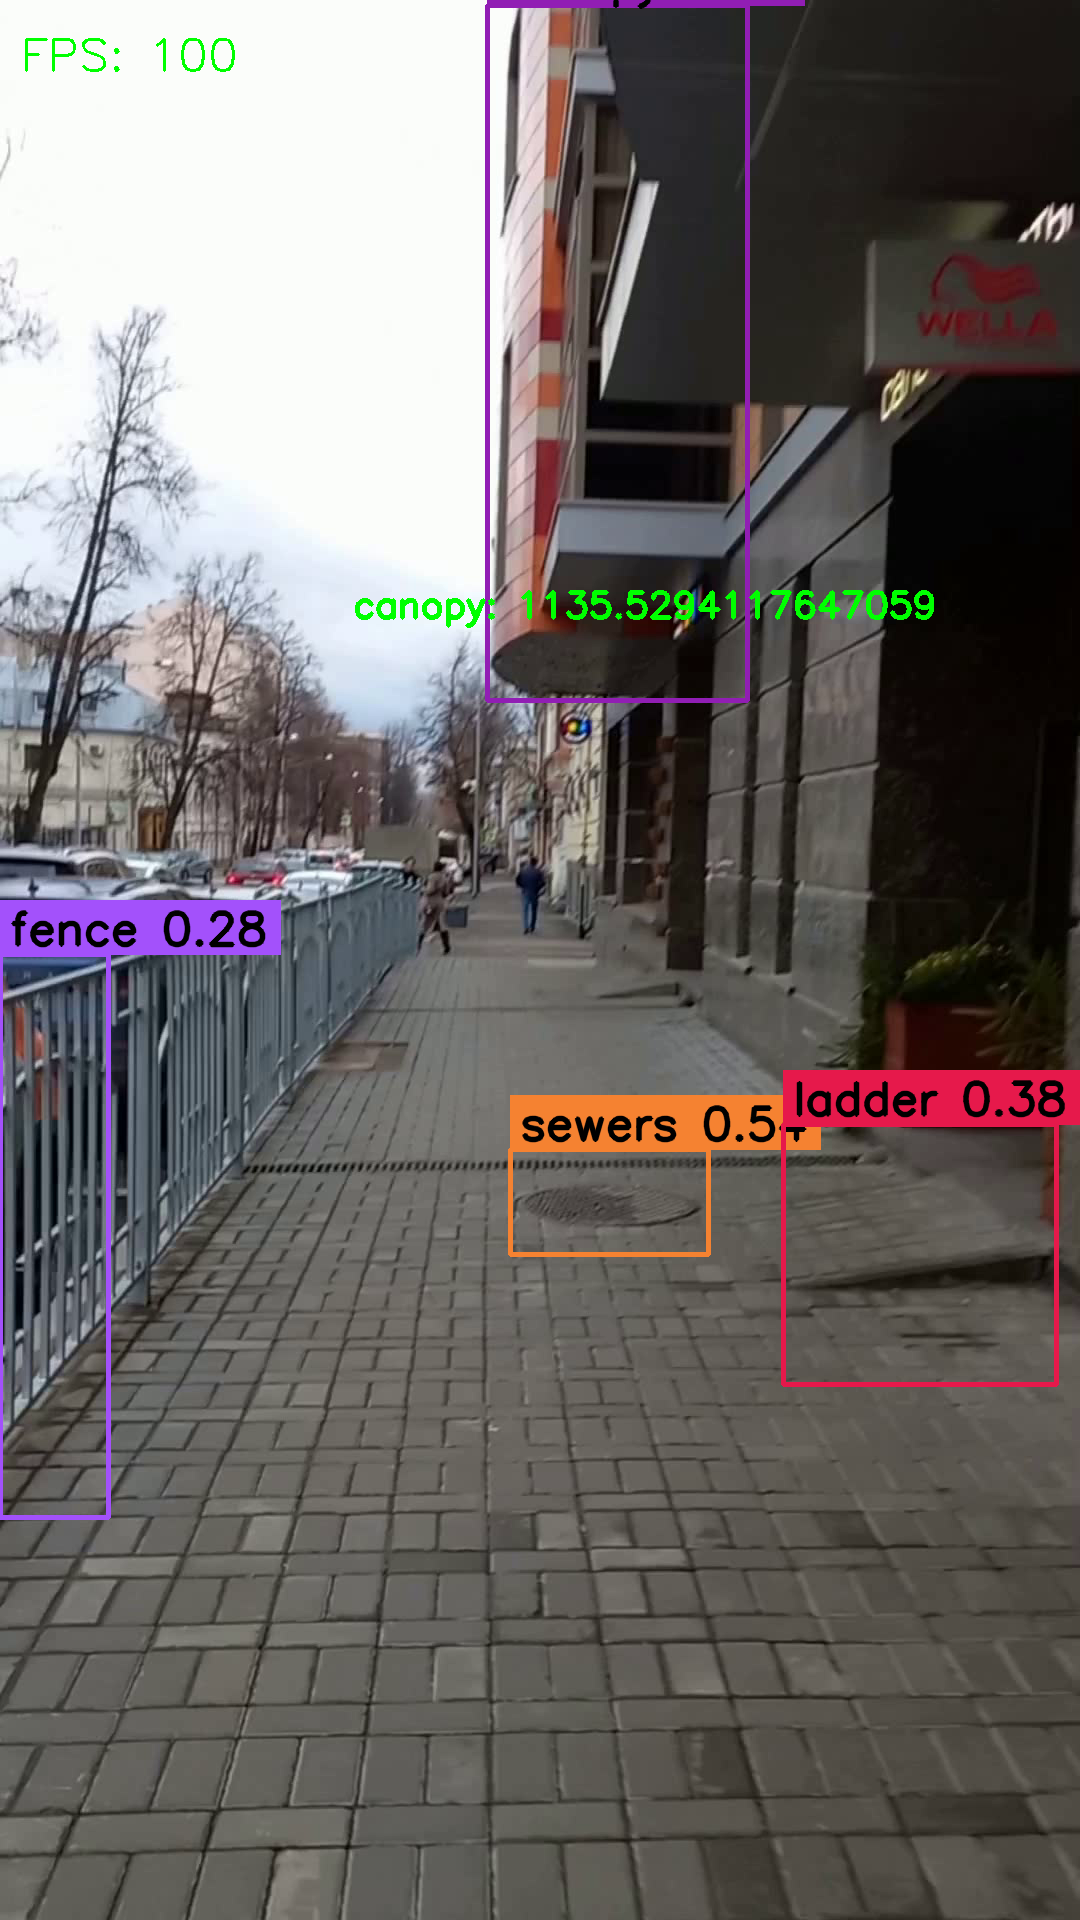

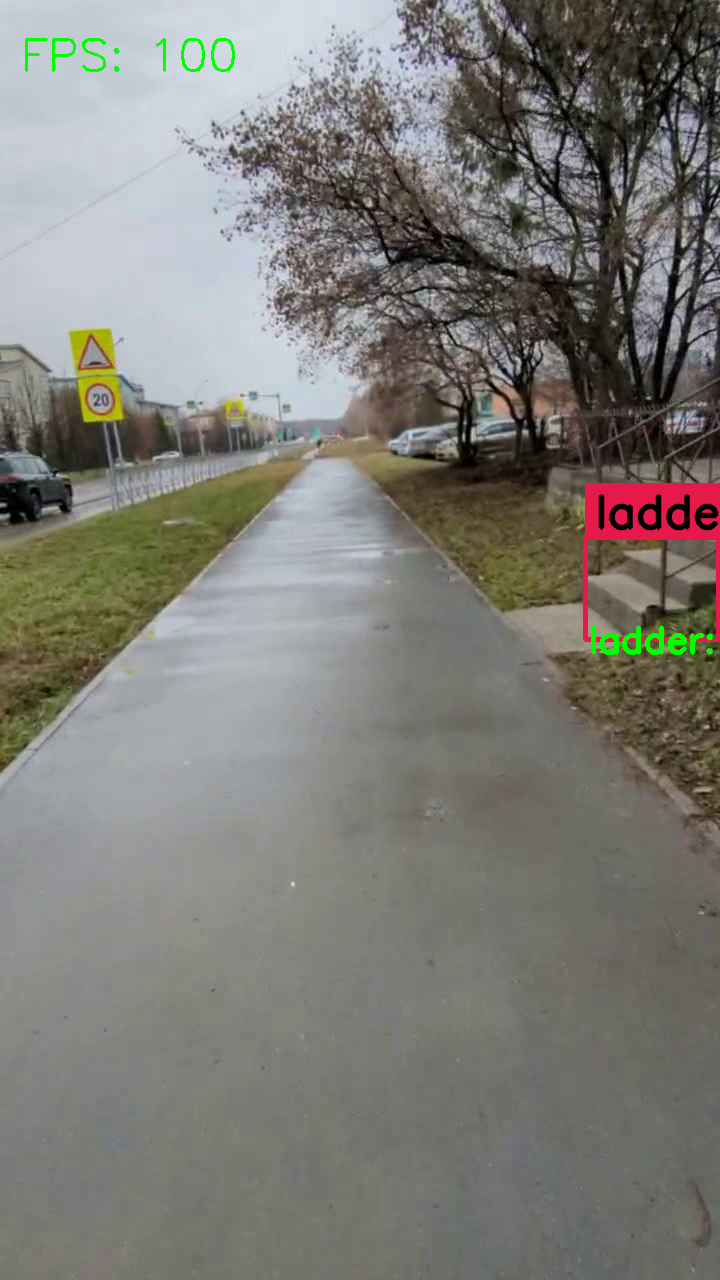

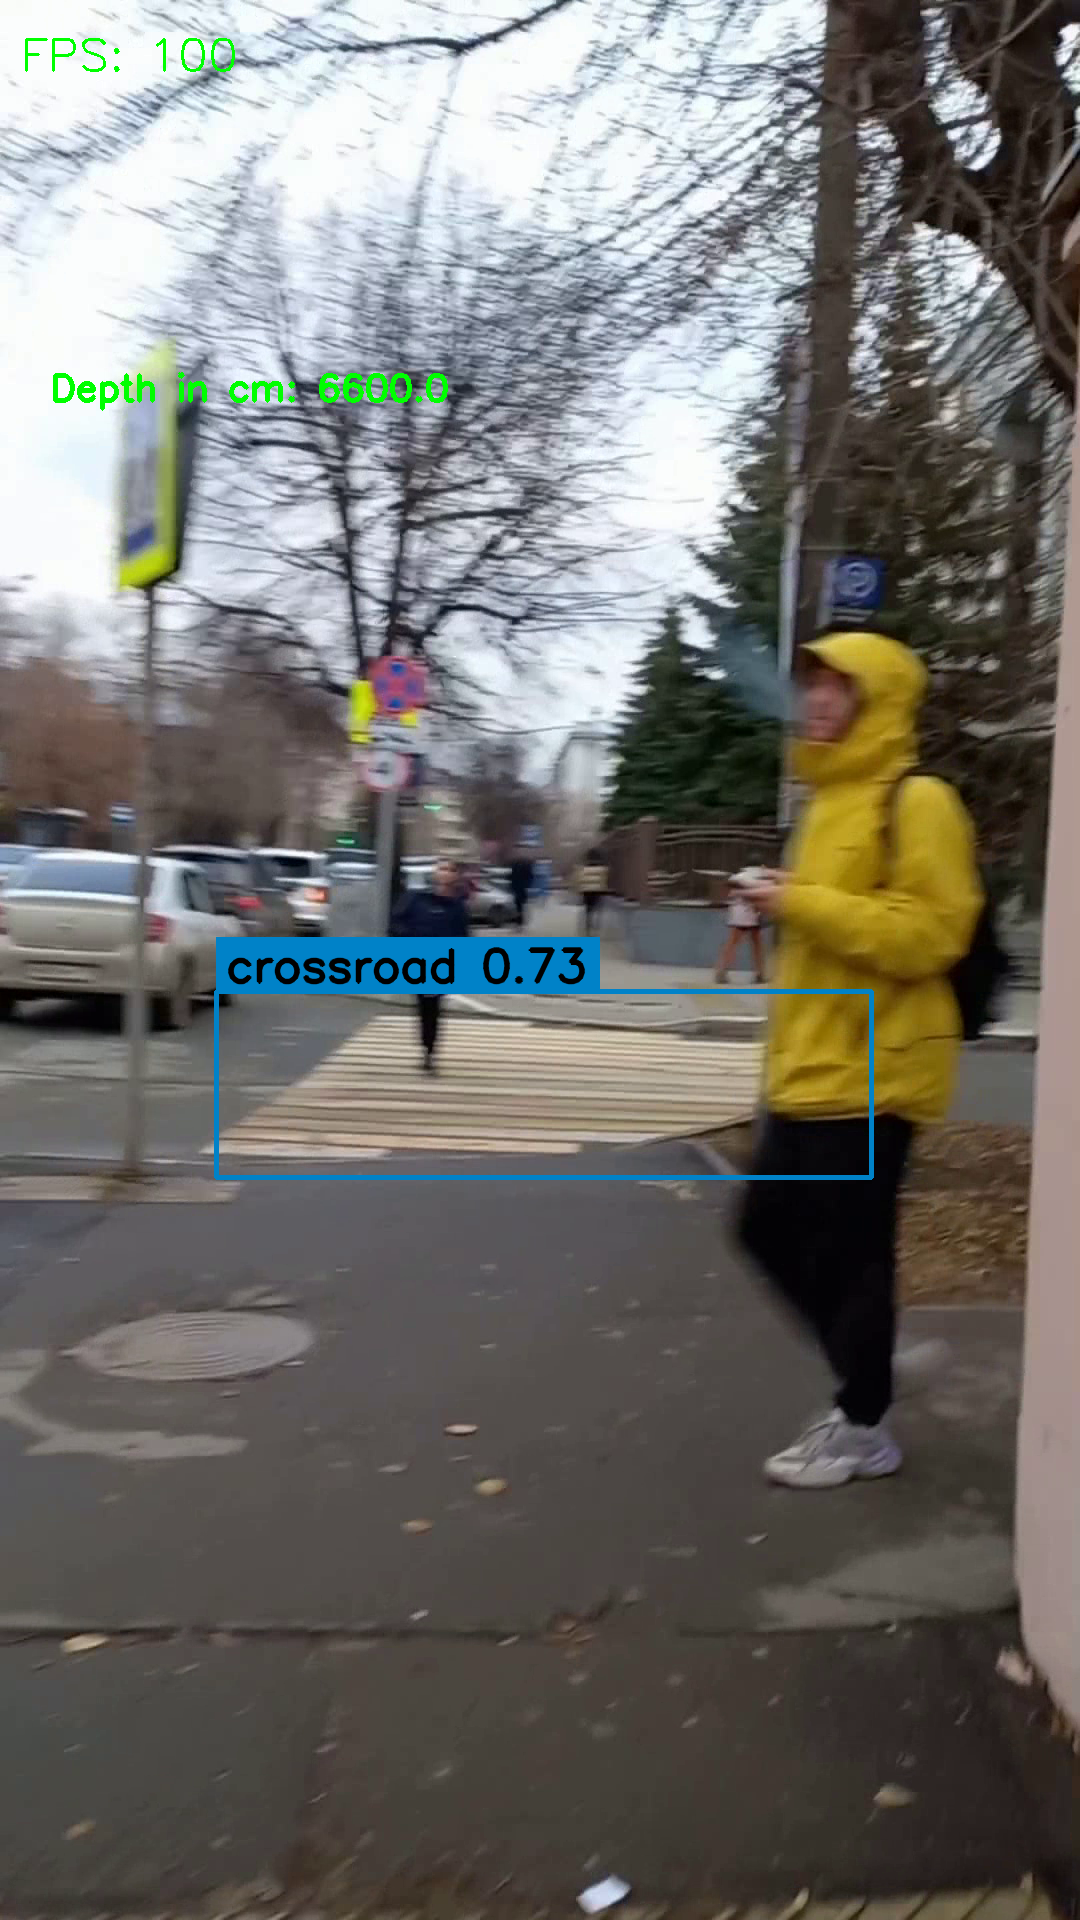

In [1]:
!pip install supervision
!pip install ultralytics
!pip install timm
!pip install mediapipe

In [4]:
!pwd

/home/data/thesis/CV/Final_submision


please change the root directory to the path that shown by running pwd

In [ ]:
ROOT_DIR = "/home/data/thesis/CV/Final_submision/"

# Preprocess The Training Video 

In the following code we preprocessed the training dataset by doing the following:
1. split the video per frame.
2. split the annotation per frame.  (Yolov8) format
3. split the preprocessed data to train and validation dataset.

NOTE: Please make sure that the Train folder is inside the ROOT_DIR

In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET
from tqdm import tqdm


label_folder = ROOT_DIR + "Train/labels"
video_folder = ROOT_DIR + "Train/videos"


class_mapping = {
    'fence': 0,
    'ladder': 1,
    'bench': 2,
    'puddle': 3,
    'crossroad': 4,
    'sewers': 5,
    'canopy': 6,
    'gate': 7
}

# Create folders to save YOLO-formatted annotation files and frames for each video
def create_folders(output_annotations_folder, output_images_folder):
    os.makedirs(output_annotations_folder, exist_ok=True)
    os.makedirs(output_images_folder, exist_ok=True)

# Get a list of XML label files in the label folder
label_files = [file for file in os.listdir(label_folder) if file.endswith(".xml")]

# Split the videos into training and validation sets
train_videos = label_files
val_videos = label_files[9:]

# Function to save frames and annotations for a given set of videos
def save_frames_and_annotations(video_set, output_annotations_folder, output_images_folder):
    for label_file in tqdm(video_set, desc="Processing videos"):
        # Construct the full paths for the XML label file and the corresponding video file
        xml_file_path = os.path.join(label_folder, label_file)
        video_file_path = os.path.join(video_folder, os.path.splitext(label_file)[0] + ".mp4")

        # Check if the video file exists
        if not os.path.exists(video_file_path):
            print(f"Video file not found for label file: {label_file}")
            continue

        # Load the XML file
        tree = ET.parse(xml_file_path)
        root = tree.getroot()

        # Open the video capture
        cap = cv2.VideoCapture(video_file_path)

        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                break

            # Parse XML to get bounding box information for the current frame
            frame_number = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
            bounding_boxes = [((float(box.get("xtl")), float(box.get("ytl"))), (float(box.get("xbr")), float(box.get("ybr"))), track.get("id"), track.get("label"))
                    for track in root.iter("track") if track.get("source") == "manual"
                    for box in track.iter("box") if int(box.get("frame")) == frame_number]

            # Save YOLO-formatted annotation file and corresponding frame
            if bounding_boxes:
                annotation_file_path = os.path.join(output_annotations_folder, os.path.splitext(label_file)[0] + f"_frame_{frame_number}.txt")
                with open(annotation_file_path, 'w') as annotation_file:
                    for bbox in bounding_boxes:
                        x_center = (bbox[0][0] + bbox[1][0]) / (2 * frame.shape[1])
                        y_center = (bbox[0][1] + bbox[1][1]) / (2 * frame.shape[0])
                        width = (bbox[1][0] - bbox[0][0]) / frame.shape[1]
                        height = (bbox[1][1] - bbox[0][1]) / frame.shape[0]

                        # Write the YOLO-formatted annotation to the file
                        annotation_file.write(f"{class_mapping[bbox[3].lower()]} {x_center} {y_center} {width} {height}\n")

                output_frame_path = os.path.join(output_images_folder, os.path.splitext(label_file)[0] + f"_frame_{frame_number}.jpg")
                cv2.imwrite(output_frame_path, frame)

        # Release the video capture
        cap.release()

# Create folders for training set
create_folders(ROOT_DIR + "dataset_train/labels/train", ROOT_DIR + "dataset_train/images/train")

# Save frames and annotations for training set
save_frames_and_annotations(train_videos, ROOT_DIR +"dataset_train/labels/train", ROOT_DIR + "dataset_train/images/train")

# Create folders for validation set

create_folders(ROOT_DIR + "dataset_train/labels/val", ROOT_DIR + "dataset_train/images/val")

# Save frames and annotations for validation set
save_frames_and_annotations(val_videos, ROOT_DIR + "dataset_train/labels/val", ROOT_DIR + "dataset_train/images/val")

# Train preprocessed data in yolov8 for object detection

In [ ]:
### Train model ###
import os
from ultralytics import YOLO
# Load a model
model = YOLO("yolov8n.pt")  # load pre trained model
CONFIG_PATH = ROOT_DIR + "config.yaml"
# Use the model
results = model.train(data=CONFIG_PATH, epochs=1,batch=4)  # train the model

# predict bounding box and calculate depth estimation
    The follwoing prediction will be per video, so if you want the result from all the videos on test, 
    
    change the path of video in the follwoing code

In [ ]:
PATH_YOLO_BEST = ROOT_DIR + "ultralytics/runs/detect/train9/weights/best.pt"

In [ ]:
VIDEO_PATH = "/home/data/thesis/CV/train_data/dataset_test/Test/Videos/stairs_1.mp4"
OUTPUT_Folder_PATH = "/home/data/thesis/CV/train_data/dataset_test/Ladder_1/"
label_base='stairs_1'

In [ ]:
if label_base == 'stairs_1'      #this because of the different naming style between the training and test
    label_base='Ladder_1'
label_base = label_base[:-2].lower()
label_base

In [ ]:
"""
Saving format will be as following example:
$Ladder_1
        |ouput_frames:
            |1
                |output_csv
                |output_frames
                |data.json
            |2
                |output_csv
                |output_frames
                |data.json
            .
            .
            .
            1.mp4
            2.mp4
            ...
"""

In [ ]:
import os
import torch
import numpy as np
import cv2
from time import time
from ultralytics import YOLO
import supervision as sv
from supervision.draw.color import ColorPalette
from supervision.detection.core import Detections
import pandas as pd
import json

# Load a MiDas model for depth estimation
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform


def depth_to_distance(depth,refrence_depth):
    """
        estimation of the real distance in (cm) of detected object based on depth map and refrence 
        (we used closest ground point as refrence) and from the train dataset,
        we noticed that it is ~228 cm far
    """
    return refrence_depth / depth * 228        


def split_video(input_video_path, output_prefix='output_part_', num_parts=10):
    """
    in this function we split the 10 seconds video to 10 videos each one of them is 1 second
    """
    # Open the video file
    cap = cv2.VideoCapture(input_video_path)

    if not cap.isOpened():
        print("Error: Could not open video file.")
        return

    # Get video properties
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Calculate the number of frames per part
    frames_per_part = frame_count // num_parts

    # Read and save each part
    for part in range(num_parts):
        
        # Set the starting frame for this part
        start_frame = part * frames_per_part

        # Set the end frame for this part
        end_frame = start_frame + frames_per_part
        
        if part == num_parts - 1:
            # Adjust end frame for the last part to include any remaining frames
            end_frame = frame_count

        # Set the output file name
        output_path = f"{output_prefix}{part + 1}.mp4"

        # Create VideoWriter object
        out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
        
        # Read and write frames for this part
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        for frame_number in range(start_frame, end_frame):
            ret, frame = cap.read()
            if not ret:
                break
            out.write(frame)
        
        # Release VideoWriter
        out.release()
        
        print(f"Part {part + 1} saved as {output_path}")

    # Release VideoCapture
    cap.release()




class ObjectDetection:

    def __init__(self, capture_index):
        self.capture_index = capture_index
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("Using Device: ", self.device)
        self.model = self.load_model()
        self.CLASS_NAMES_DICT = self.model.model.names
        self.box_annotator = sv.BoxAnnotator(color=ColorPalette.default(), thickness=3, text_thickness=3, text_scale=1.5)
        self.output_folder = OUTPUT_Folder_PATH  # Change this to your desired output folder
        os.makedirs(self.output_folder, exist_ok=True)
        self.frame_counter = 0

    def load_model(self):
        model = YOLO(PATH_YOLO_BEST)  # load a pretrained YOLOv8n model
        model.fuse()
        return model

    def predict(self, frame):
        results = self.model(frame)
        return results

    def plot_bboxes(self, results, frame):
        xyxys = []
        confidences = []
        class_ids = []

        for result in results[0]:
            class_id = result.boxes.cls.cpu().numpy().astype(int)

            if class_id == 0:
                xyxys.append(result.boxes.xyxy.cpu().numpy())
                confidences.append(result.boxes.conf.cpu().numpy())
                class_ids.append(result.boxes.cls.cpu().numpy().astype(int))

        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int),
        )

        self.labels = [f"{self.CLASS_NAMES_DICT[class_id]} {confidence:0.2f}" for _, _, confidence, class_id, tracker_id
                      in detections]

        frame = self.box_annotator.annotate(scene=frame, detections=detections, labels=self.labels)

        # Print center of bounding box
        center_x =[]
        center_y = []
        for (box, _, _, _, _), label in zip(detections, self.labels):
            x1, y1, x2, y2 = box
            center_x.append(  int((x1 + x2) / 2))
            center_y.append( int((y1 + y2) / 2))
            #print(f"Center of {label}: ({center_x[-1]}, {center_y[-1]})")
        return frame, center_x, center_y , self.labels

    def save_frame(self, frame,path,count,label_data):
        os.makedirs(path+"/ouput_frames/", exist_ok=True)
        output_path = os.path.join(path+"/ouput_frames/", f"{count}.png")
        cv2.imwrite(output_path, frame)
        df = pd.DataFrame(label_data)
        os.makedirs(path+"/ouput_csv/", exist_ok=True)
        csv_file_path = os.path.join( path+"/ouput_csv/", f"{count}.csv")
        df.to_csv(csv_file_path, index=False)
        self.frame_counter += 1

    def __call__(self):
        # put the path to the wanted output folder here 
        output_prefix = OUTPUT_Folder_PATH
        
        # put the path to the video here
        split_video(VIDEO_PATH,output_prefix=output_prefix)
        for i in range(1,11):
            data = []
            cap = cv2.VideoCapture(output_prefix+f'{i}.mp4')
            #assert cap.isOpened()
            count = 0
            while True:
                start_time = time()
                ret, frame = cap.read()
                #assert ret
    
                results = self.predict(frame)
                frame, center_x, center_y , labelss= self.plot_bboxes(results, frame)
    
                end_time = time()
                fps = 1/np.round(end_time - start_time, 2)
                cv2.putText(frame, f'FPS: {int(fps)}', (20,70), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0), 2)
    
                success, img = cap.read()
    
                if not success:
                    break
    
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                input_batch = transform(img).to(device)
    
                with torch.no_grad():
                    prediction = midas(input_batch)
    
                    prediction = torch.nn.functional.interpolate(
                        prediction.unsqueeze(1),
                        size=img.shape[:2],
                        mode="bicubic",
                        align_corners=False,
                    ).squeeze()
    
                depth_map = prediction.cpu().numpy()
    
                depth_map = cv2.normalize(depth_map, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)
    
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
                depth_map = (depth_map*255).astype(np.uint8)
                if len(center_y)==0:
                    continue
                label_data = []
                for j in range(len(center_y)):
                    label_data_dic={}
                    depth_obj = depth_map[int(center_y[j]), int(center_x[j])]
                    label_data_dic['depth_obj']=int(depth_obj)
                    label_data_dic['label']=str(labelss[j])
                    label_data_dic['center_y']=int(center_y[j])
                    label_data_dic['center_x']=int(center_x[j])
                    print(int(center_y[j]), int(center_x[j]),labelss[j])
                    print(depth_obj)
                    print(depth_map.shape)
                    print(frame.shape)
                    refrence_depth = depth_map[ int(frame.shape[0])-1,int(frame.shape[1]/2)]
                    depth_obj = depth_to_distance(depth_obj,refrence_depth)
                    print("refrence_depth", refrence_depth)
                    print("Depth to obj: ", depth_obj)
                    label_data_dic["refrence_depth"]= int(refrence_depth)
                    label_data_dic["Depth_to_obj"]= int(depth_obj)
                    label_data.append(label_data_dic)
                    cv2.putText(frame, f"{str(labelss[j]).split(' ')[0]}: {str(depth_obj)}"  , (int(center_y[j]), int(center_x[j])), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)
                
                data.append(label_data)
                
                self.save_frame(frame,output_prefix+f'{i}',count,label_data)
                count += 1
                #cv2.imshow(' ', frame)
                #cv2.imshow(' ', depth_map)
    
                if cv2.waitKey(5) & 0xFF == 27:
                    break
            print(data)
            # Specify the file path to save the JSON file
            json_file_path = f"{output_prefix}{i}/data.json"
            # Convert NumPy arrays to Python lists within dictionaries and lists
            def convert_np_array(item):
                if isinstance(item, np.ndarray):
                    return item.tolist()
                elif isinstance(item, dict):
                    return {key: convert_np_array(value) for key, value in item.items()}
                elif isinstance(item, list):
                    return [convert_np_array(element) for element in item]
                else:
                    return item
            
            # Apply conversion to the entire data structure
            converted_data_dict = data #{key: convert_np_array(value) for key, value in data.items()}
            
            if len(converted_data_dict)==0:
                converted_data_dict =[[]]
                os.makedirs(output_prefix+f'{i}'+"/ouput_frames/", exist_ok=True)
                # Save the converted data to a JSON file
                with open(json_file_path, 'w') as json_file:
                    json.dump(converted_data_dict, json_file, indent=4)
            # Save the converted data to a JSON file
            with open(json_file_path, 'w') as json_file:
                json.dump(converted_data_dict, json_file, indent=4)
            
            print(f"JSON file saved at: {json_file_path}")


            cap.release()
            cv2.destroyAllWindows()

detector = ObjectDetection(capture_index=0)
detector()


In [ ]:
import os
import json

# Path to the main output folder containing subfolders
main_folder_path = OUTPUT_Folder_PATH

# List to store dictionaries
data_dicts = []

# Iterate over subfolders (assuming subfolders are named 1 to 10)
for folder_name in range(1, 11):
    folder_path = os.path.join(main_folder_path, str(folder_name))

    # Ensure the folder exists
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        # Dictionary to store data from the JSON file
        folder_data = {}

        # Iterate over files in the subfolder
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)

            # Check if the file is a JSON file
            if file_name.endswith(".json") and os.path.isfile(file_path):
                with open(file_path, 'r') as json_file:
                    # Load JSON data and store it in the dictionary
                    json_data = json.load(json_file)
                    folder_data[file_name] = json_data

        # Append the dictionary to the list
        data_dicts.append(folder_data)



In [ ]:
#speed = 225 #(second)
def depth_for_all(avr,time,speed):
    avr = avr + random.randint(-3, 3)
    distance = []
    for i in range(10):
        if avr == -1:
            distance.append(0)
            continue
        if i < time:
            distance.append(int(avr+speed*(time-i)))
        elif i == time:
            distance.append(int(avr))
        else:
            distance.append(int(avr-speed*(i-time)))
    return distance
def get_avrage_dis(dic):
    avrage = []
    for i in dic:
        for j in i:
            if j['label'].split(' ')[0] == label_base:
                avrage.append(j['Depth_to_obj'])
    if len(avrage) == 0:
        return -1
    average_value = sum(avrage) / len(avrage)
    return average_value
matrix = []
for i in range(10):
    avg = get_avrage_dis(data_dicts[i]['data.json'])
    print(avg)
    matrix.append(avg)
matrix

In [ ]:
refrence = () 
speed = 0
for j in range(9,-1,-1):
    if matrix[j] == -1:
        continue
    refrence = (j,matrix[j])
    break
recorded = []
for j in range(9,-1,-1):
    if matrix[j] == -1:
        continue
    recorded.append((j,matrix[j]))
if len(recorded)== 1:
    speed = 110
else:
    avrage_speed = []
    for i in range(len(recorded)-1):
        avrage_speed.append(abs(recorded[i+1][1]-recorded[i][1])*(abs(recorded[i+1][0]-recorded[i][0])))
    speed = sum(avrage_speed) / len(avrage_speed)
    print(avrage_speed)

    
print("final speed:", speed)

In [ ]:
final_distance = depth_for_all(refrence[1],refrence[0],speed)
final_distance

In [ ]:
if speed >170 :
    final_distance = [ final_distance[i]/(speed/170) for i in range(len(final_distance)) ]
final_distance = [int(final_distance[i]/1.2) for i in range(len(final_distance)) ]
final_distance

In [ ]:
import csv
import pandas as pd
output_place = {"fence":0,"canopy":1,"crossroad":2,"gate":3,"puddle":4,"sewers":5,"ladder":6}
# Specify the path to your CSV file
csv_file_path = "/home/data/thesis/CV/train_data/final_csv.csv"
df = pd.read_csv(csv_file_path)
count = 0
for i in range(10):
    print(i)
    df.iloc[i+10*output_place[label_base],1] = final_distance[count]
    count+=1
df.to_csv(csv_file_path, index=False)